In [87]:
import sys
sys.path.append('../')

%matplotlib inline
import torch
from dynamic_graph import *
import math
import re
import copy
import random
from tqdm import tqdm

In [131]:
def visualize(graph, pos=None, node_size=550, edge_size=14, edge_label=True):
        
    if pos == None:
        pos = {str(n): 0.5*np.array([np.cos(2 * np.pi * n / graph.n_nodes), np.sin(2 * np.pi * n / graph.n_nodes)]) for n in range(graph.n_nodes)}
    ax = plt.figure(figsize=(3*graph.length,3))
    
    options = {
        "font_size": 15,
        "node_size": node_size,
        "node_color": "lightgray",
        "edgecolors": "black",
        "linewidths": 3,
        "width": 3,
    }
    
    plt.subplots_adjust(wspace=0.4)
    
    for t in range(graph.length):
        plt.subplot(1, graph.length, t+1)
        G = nx.Graph()
        edge_labels = {}
            
        for i in range(graph.n_nodes):
            G.add_node(str(i))
                
            for i in range(graph.n_nodes):
                for j in range(graph.n_nodes):
                    if i > j:
                        if graph.w_list[t][i,j] > 0:
                            G.add_edge(str(i), str(j))
                        
                            # edge weight
                            if math.isclose(graph.w_list[t][i,j].item(), 0.5):    
                                edge_labels[(str(i), str(j))] = "1/2"
                            elif math.isclose(graph.w_list[t][i,j].item(), 2/3):
                                edge_labels[(str(i), str(j))] = "2/3"
                            elif math.isclose(graph.w_list[t][i,j].item(), 1/3):
                                edge_labels[(str(i), str(j))] = "1/3"
                            elif math.isclose(graph.w_list[t][i,j].item(), 4/5):
                                edge_labels[(str(i), str(j))] = "4/5"
                            elif math.isclose(graph.w_list[t][i,j].item(), 1/5):
                                edge_labels[(str(i), str(j))] = "1/5"
                            elif math.isclose(graph.w_list[t][i,j].item(), 4/7):
                                edge_labels[(str(i), str(j))] = "4/7"
                            else:
                                edge_labels[(str(i), str(j))] = "??"
        ax = plt.gca()
        ax.margins(0.20)
        plt.axis("off")

        nx.draw(G, pos=pos, labels={str(i) : str(i) for i in range(graph.n_nodes)}, **options)
        
        if edge_label:
            nx.draw_networkx_edge_labels(
                G, pos,
                edge_labels,
                font_color='black',
                font_size=edge_size)

In [216]:
import torch
from dynamic_graph import *
import math
import re
import copy
import random
import sympy

class HyperHyperCube(DynamicGraph):
    def __init__(self, n_nodes, seed=0, max_degree=1):
        self.state = np.random.RandomState(seed)
        self.max_degree = max_degree
        
        if list(sympy.factorint(n_nodes))[-1] > max_degree+1:
            print(f"Can not construct {max_degree}-peer graphs")
        
        node_list = list(range(n_nodes))
        factors_list = self.split_node(node_list, n_nodes)
        
        super().__init__(self.construct(node_list, factors_list, n_nodes))
    
    def construct(self, node_list, factors_list, n_nodes):
        w_list = []
        for k in range(len(factors_list)):
            w = torch.zeros((n_nodes, n_nodes))
            b = torch.zeros(n_nodes)
            
            for i_idx in range(len(node_list)):
                for nk in range(1, factors_list[k]):
                    
                    i = node_list[i_idx]
                    j = int(i + np.prod(factors_list[:k]) * nk) % n_nodes
                    
                    if b[i] < factors_list[k]-1 and b[j] < factors_list[k]-1:
                        #print("g", i, j, b[i], b[j])
                        b[i] += 1
                        b[j] += 1
                        
                        w[i, j], w[j, i] = 1/factors_list[k], 1/factors_list[k]
                        w[i, i], w[j, j] = 1/factors_list[k], 1/factors_list[k]
                        
            w_list.append(w)
       
        return w_list
                    

    def split_node(self, node_list, n_nodes):
        factors = sympy.factorint(n_nodes)
        factors_list = []
        for factor in factors:
            factors_list += [factor for _ in range(factors[factor])]

        counter = 0
        while True:
            if len(factors_list) == 1:
                break
            
            first_min_factor = factors_list[0]
            second_min_factor = factors_list[1]
            
            marged_factor = first_min_factor*second_min_factor
            if marged_factor <= self.max_degree+1:
                factors_list.pop(0)
                factors_list.pop(0)
                factors_list.append(marged_factor)
                factors_list.sort()
            else:
                break
        return factors_list


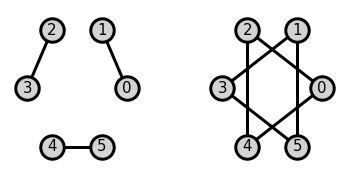

In [217]:
g = HyperHyperCube(6, max_degree=2)
visualize(g, edge_label=False)

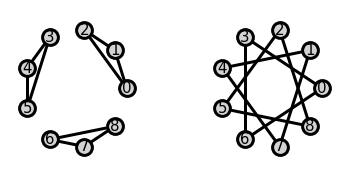

In [228]:
g = HyperHyperCube(9, max_degree=2)
visualize(g, node_size=250, edge_label=False)

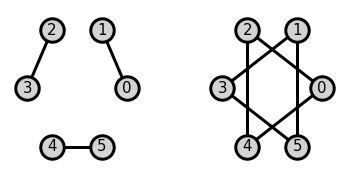

In [230]:
g = HyperHyperCube(6, max_degree=2)
visualize(g, edge_label=False)

Can not construct 2-peer graphs


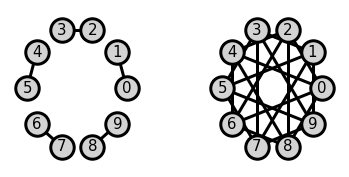

In [231]:
g = HyperHyperCube(10, max_degree=2)
visualize(g, edge_label=False)

In [223]:
init_w = torch.eye(18)
for w in g.w_list:
    init_w = init_w.matmul(w)
print(init_w)

tensor([[0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556,
         0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556,
         0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556,
         0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556,
         0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556,
         0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556,
         0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556, 0.0556],
        [0.0556, 0.055

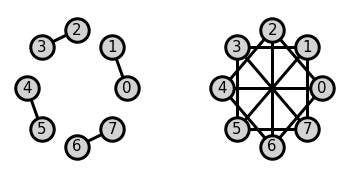

In [157]:
g = HyperHyperCube(8, max_degree=3)
visualize(g, edge_label=False)

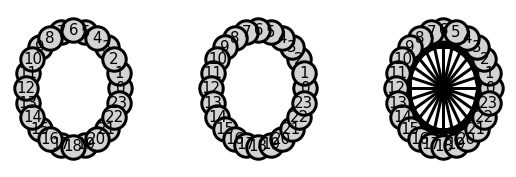

In [162]:
g = HyperHyperCube(24, max_degree=3)
visualize(g, edge_label=False)